# 0.0 IMPORTS

In [217]:
import datetime
import inflection
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb

from IPython.display import Image
from IPython.display import HTML
from tabulate import tabulate

from scipy import stats
from boruta import BorutaPy

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor







## 0.1 Helper functions

In [181]:
from stat import FILE_ATTRIBUTE_OFFLINE


def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
   # for pandas to display the complete dataframe, with no restriction on the number of columns to be displayed, I can change the following option:
    #pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v(x,y):  
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])




In [106]:
jupyter_settings()

## 0.2 Loading data

In [107]:
df_sales_raw = pd.read_csv(r"data\train.csv", low_memory=False)
df_stores_raw = pd.read_csv("data\store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw,df_stores_raw,how='left',on='Store')

# 1.0 DATA DESCRIPTION

In [108]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [109]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase,cols_old))

# rename
df1.columns = cols_new


## 1.2 Data dimensions

In [110]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data types

In [111]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [112]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [113]:
df1['competition_distance'].max()

75860.0

In [114]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

              

In [115]:
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                      1 if x['month_map'] in x['promo_interval'] else 0, axis = 1)


 
     


## 1.6 Change types

In [116]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64) 

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 1.7 Descriptive statistical

In [117]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical attributes

In [118]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


c:\Users\diego\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


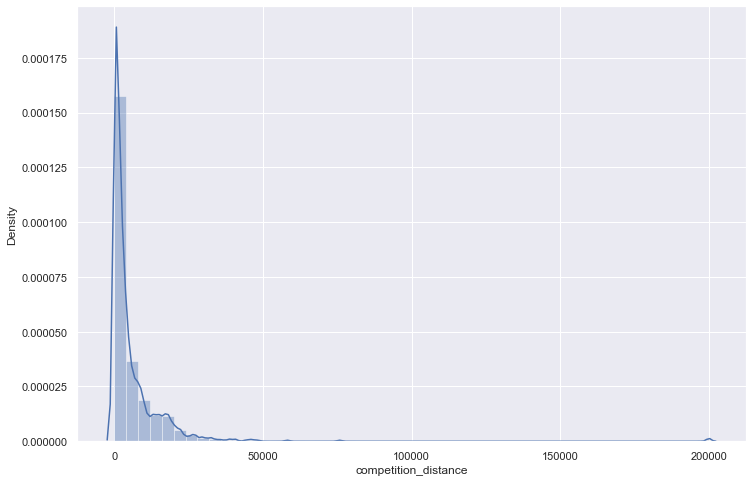

In [119]:
sns.distplot(df1['competition_distance']);

### 1.7.1 Categorical attributes

In [120]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

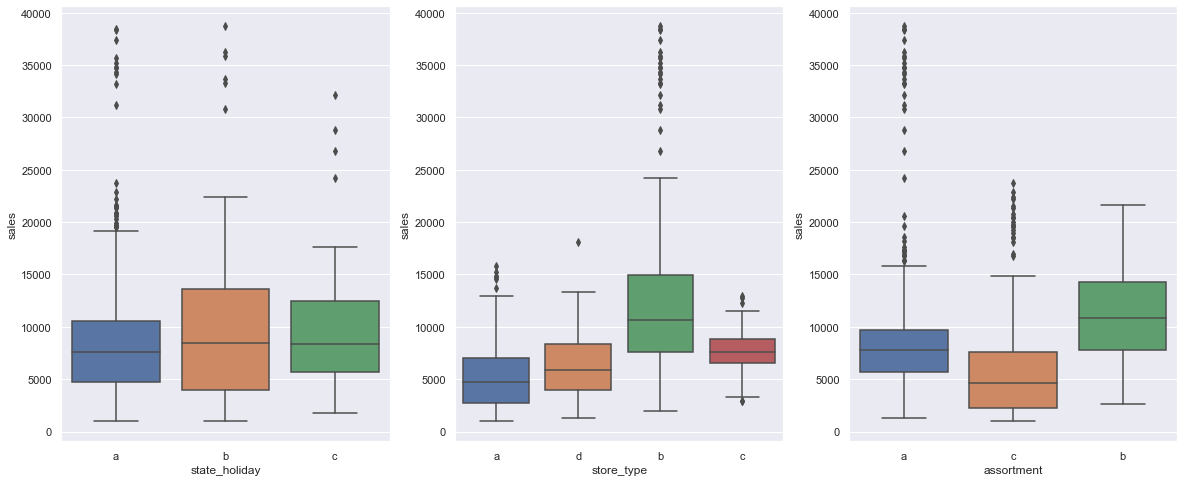

In [121]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [122]:
df2 = df1.copy()

## 2.1 Mindmap Hypotheses

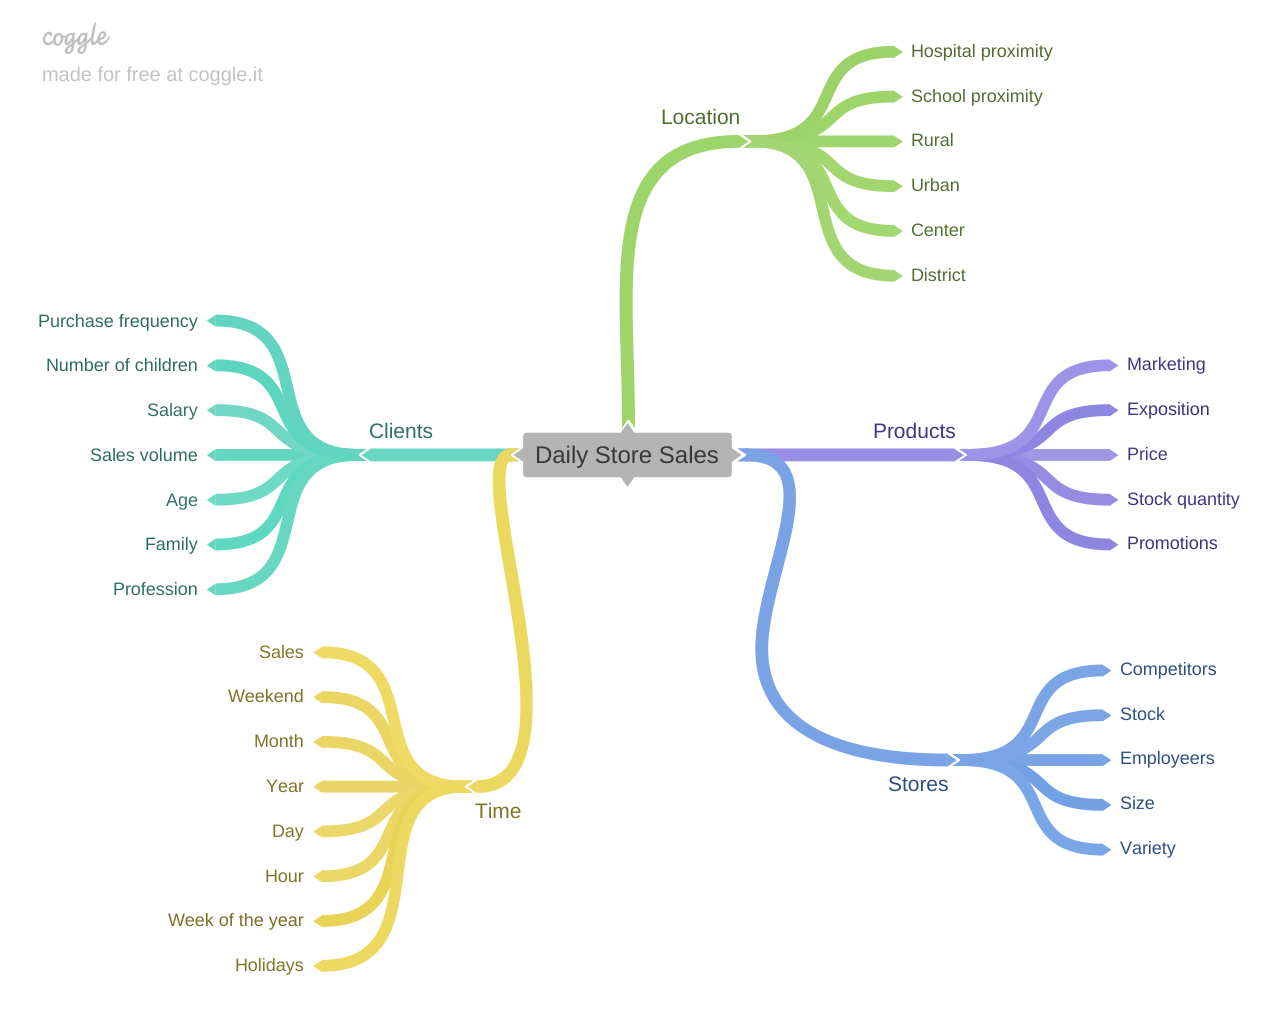

In [123]:
Image('img\Mind_Map_Hip.png')

## 2.2 Hypotheses

### 2.2.1 Stores Hypotheses

1. Stores with more employees should sell more
2. Stores with more inventory should sell more
3. Bigger stores should sell more (or smaller stores should sell less)
4. Stores with a larger assortment should sell more
5. Stores with closer competitors should sell less
6. Stores with longer-standing competitors should sell more

### 2.2.2 Products Hypotheses

1. Stores that invest more in marketing should sell more
2. Stores that display more in store windows should sell more
3. Stores where products cost less should sell more
4. Stores with more aggressive promotions (larger discounts) should sell more
5. Stores where products cost less for longer (active promotions) should sell more
6. Stores with more promotion days should sell more
7. Stores with more extended promotions should sell more


### 2.2.3 Time Hypotheses

1. Stores open during Christmas holiday should sell more
2. Stores should sell more over the years
3. Stores should sell more in the second half of the year
4. Stores should sell more after the 10th day of each month
5. Stores should sell less on weekends
6. Stores should sell less during school holidays
7. Stores that open on Sundays should sell more

## 2.2 Hypotheses priorization

1. Stores with a larger assortment should sell more
2. Stores with closer competitors should sell less
3. Stores with longer-standing competitors should sell more


4. Stores where products cost less for longer (active promotions) should sell more
5. Stores with more promotion days should sell more
6. Stores with more extended promotions should sell more


7. Stores open during Christmas holiday should sell more
8. Stores should sell more over the years
9. Stores should sell more in the second half of the year
10. Stores should sell more after the 10th day of each month
11. Stores should sell less on weekends
12. Stores should sell less during school holidays

## 2.3 Feature engineering

In [124]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')-datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 VARIABLES FILTERING

In [125]:
df3 = df2.copy()

## 3.1 Row filtering

In [126]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Column filtering

In [127]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)

# 4.0 Exploratory Data Analysis

In [128]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

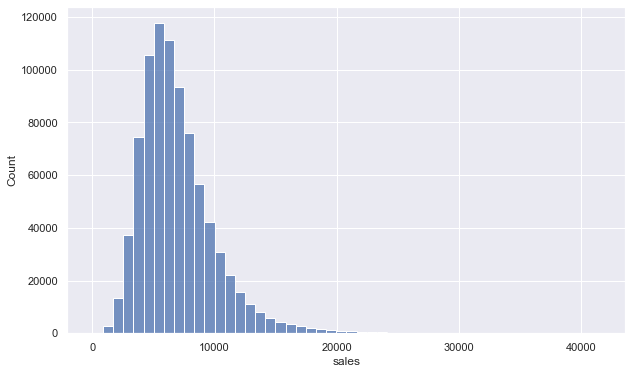

In [129]:
plt.figure(figsize=(10,6))
sns.histplot(df4['sales'],bins=50)


### 4.1.2 Numerical variable

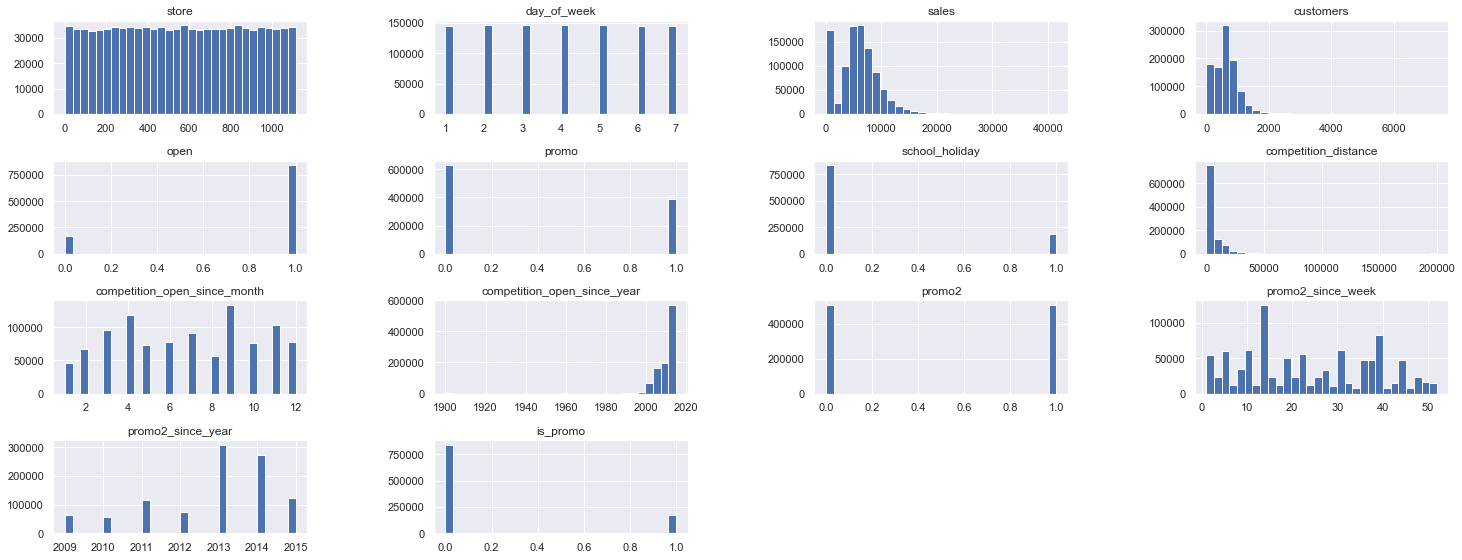

In [130]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,4));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()
    

### 4.1.3 Categorical variable

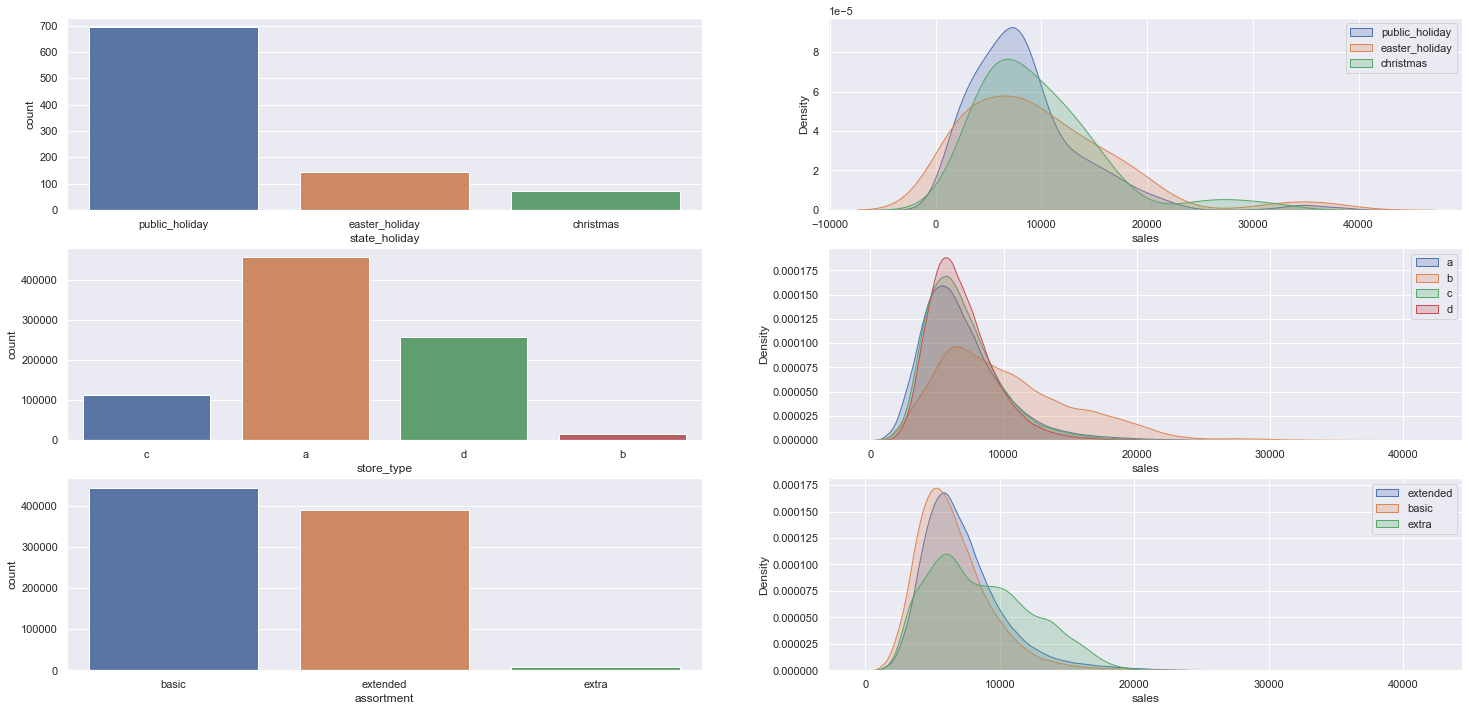

In [131]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()



## 4.2 Bivariate analysis

The prioritized hypotheses will be validated or refuted in this section

### H1. Stores with a larger assortment should sell more, on average

**True**

First, it is observed the quantity of stores of each assortment type

In [132]:
aux0 = df4[['assortment','store']].drop_duplicates().groupby('assortment').count()
aux0

,store
assortment,
basic,593
extended,513
extra,9


It is seen that the stores with basic and extended assortments are considerably larger than the extra assortment

Since it's seen this considerable variation, the analysis will be carried out through the average of sales quantity

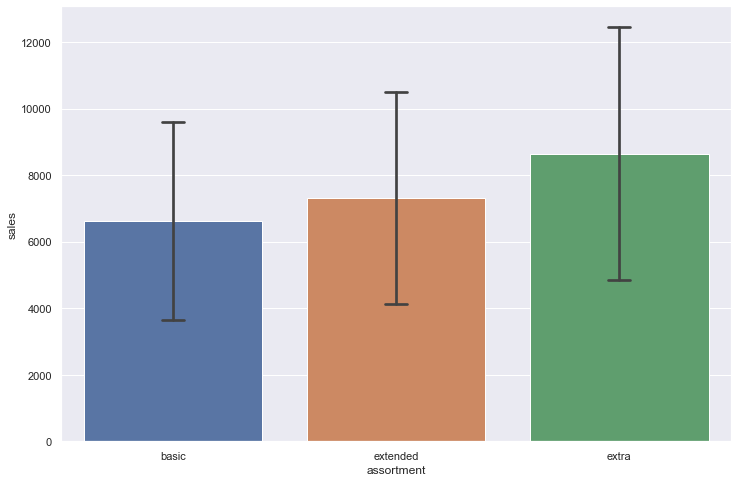

In [133]:
sns.barplot(data=df4, x='assortment', y='sales', estimator=np.mean, ci='sd',capsize=.1);


The bar chart plotted above shows that, on average, stores with extra assortment tends to sell more, followed by extended and basic assortments, respectively.

It will be plotted a time series, as a way to observe wheter or not this condition kept along the time

<AxesSubplot:xlabel='year_week'>

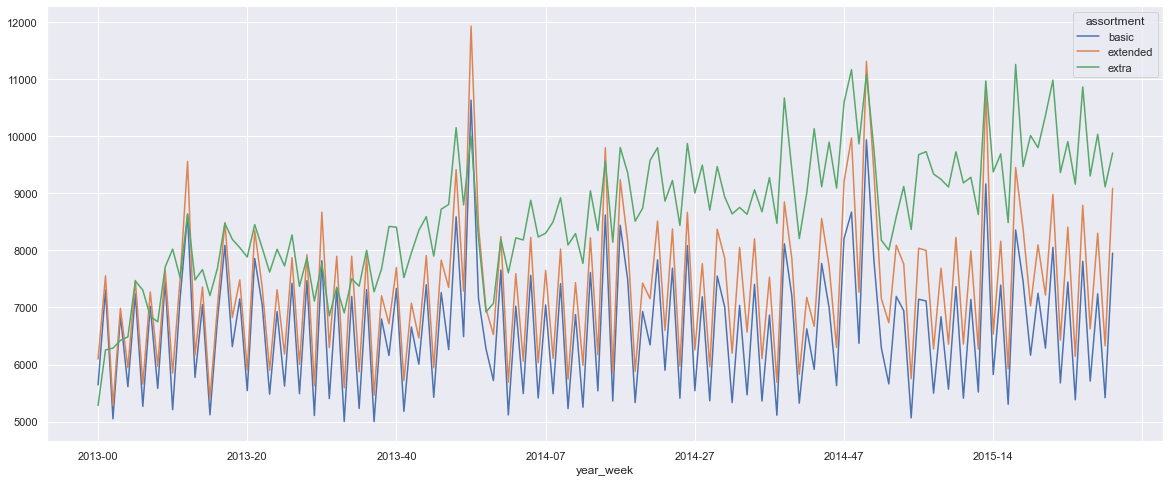

In [134]:
aux1 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week',columns='assortment', values='sales');

aux2.plot(figsize=(20,8))

The line chart shows that there is an increase of the sales as time passes for stores with extra assortment. Also, it is seen that the tendency is maintained as in the bar chart. 

The veridict of hypothesis H1 is **true, stores with large assortments tend to sell more.**

### H2. Stores with closer competitors should sell less, on average

**False**

Plotting the sales average values by distance: 

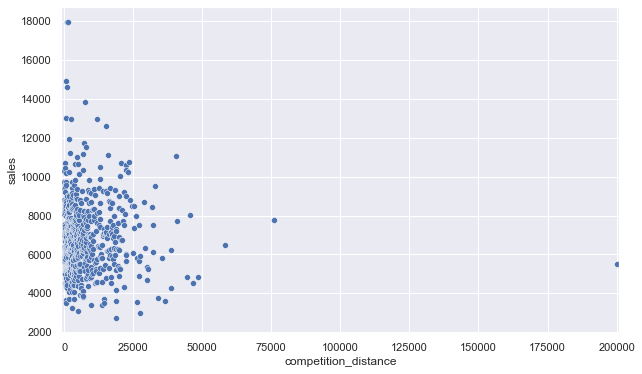

In [135]:
plt.figure(figsize=(10,6))

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)
plt.xlim(-1000,201000);


From the chart above, it is not seen apparent correlation between the sales and the competitors distance from the store.

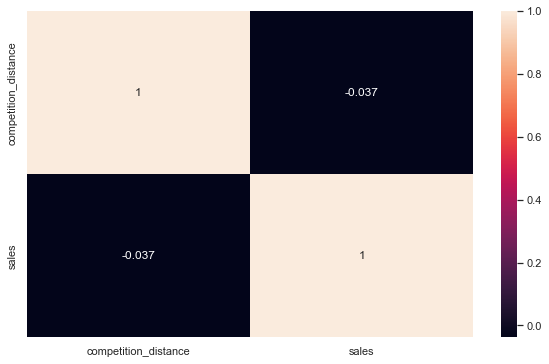

In [136]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Since the correlation between the two variables is almost none, the veridict of hypothesis is **false, stores with closer competitors don't sell less (or more) than stores with more distant competitors.**

### H3. Stores with longer-standing competitors should sell more, on average

**False**

The charts below show the average sales over the competition time (in months). This time will be limited up to 120 months.

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

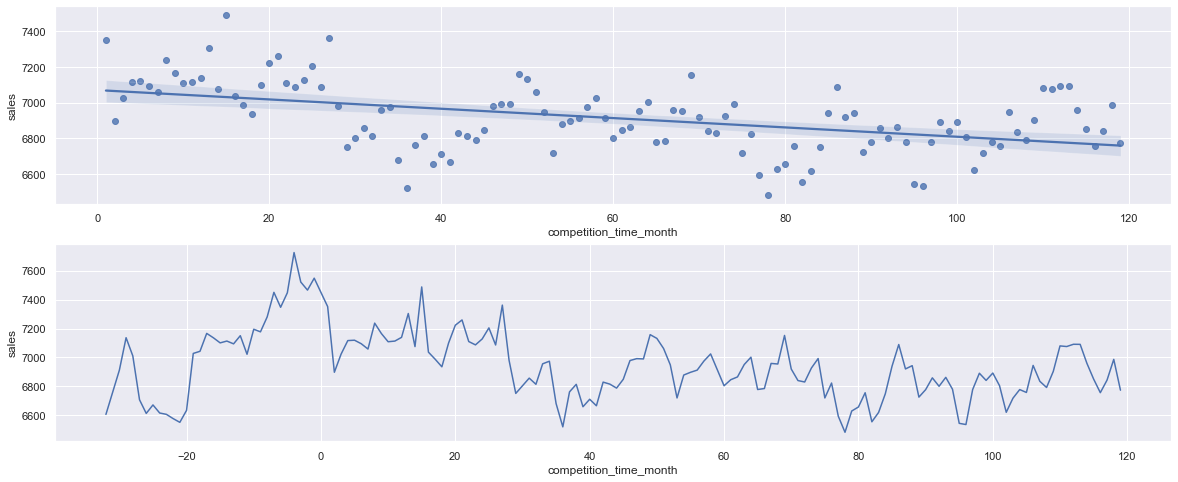

In [137]:
plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] > 0)]
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(2,1,2)
aux3 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.lineplot(x='competition_time_month', y='sales', data=aux3)

It is noticed that stores with longer-standing competitors (higher x-axis values) do not tend to sell more

Also, from the second chart it is seen a tendency of sales decrease after a new competitor opens near the store, with no recovery for at least the first 120 months (10 years).

The veridict of hypothesis H3 is **false, stores with longer-standing competitors do not sell more**

### H4. Stores where products cost less for longer (active promotions) should sell more, on average

**True**

(5000.0, 7000.0)

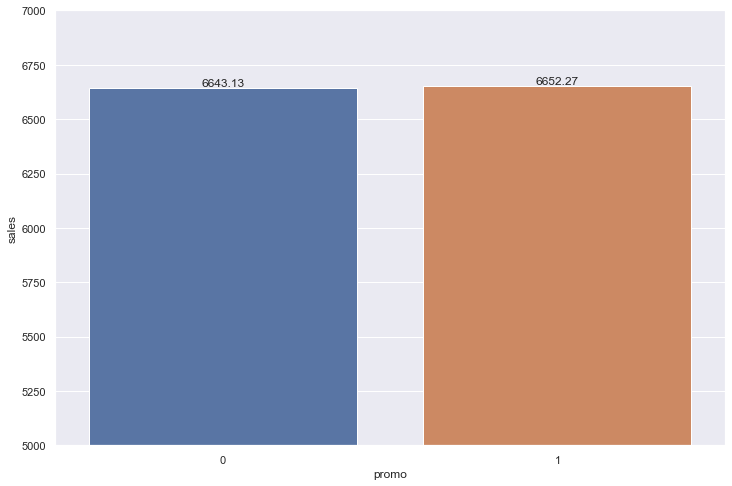

In [138]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

aux1['promo'] = aux1['promo_time_week'].apply(lambda x: 0 if x < 0 else 1)

ax = sns.barplot(x=aux1['promo'],y=aux1['sales'], ci=None)
plt.bar_label(container=ax.containers[0])
plt.ylim([5000,7000])

On average, stores with current promo do not show greater advantage over the ones with no promo  

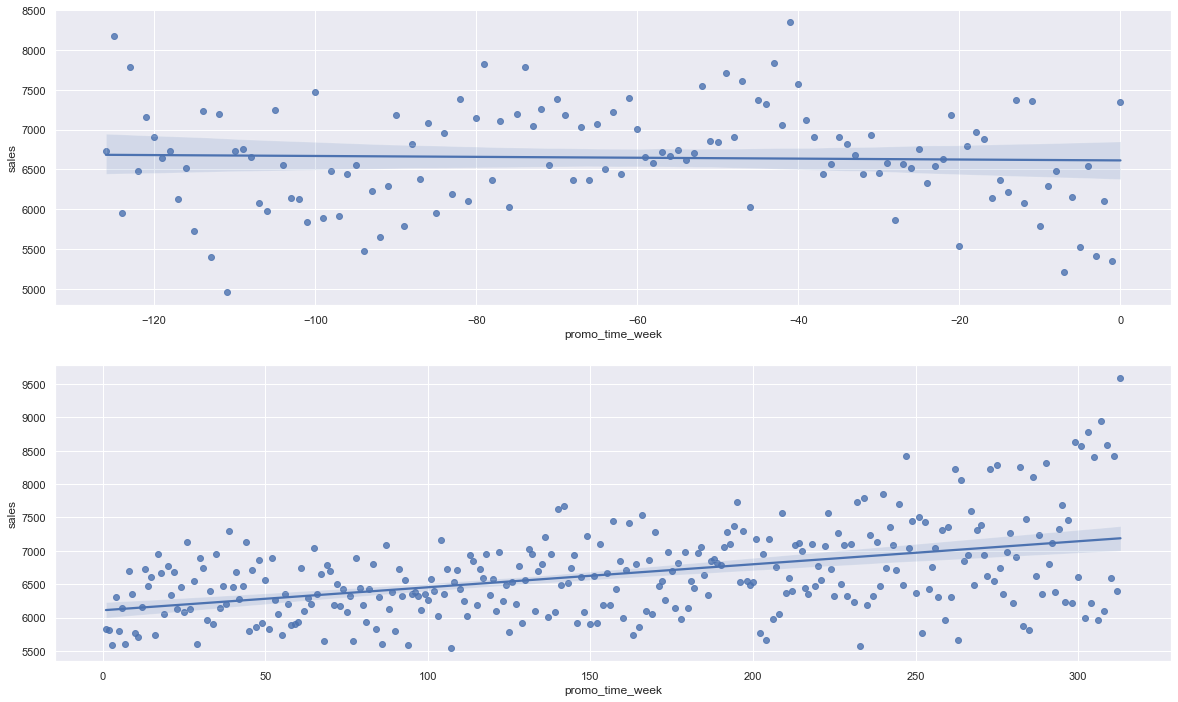

In [139]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
sns.regplot(x=aux1[aux1['promo_time_week'] <= 0]['promo_time_week'], y=aux1[aux1['promo_time_week'] <= 0]['sales']);

plt.subplot(2,1,2)
sns.regplot(x=aux1[aux1['promo_time_week'] > 0]['promo_time_week'], y=aux1[aux1['promo_time_week'] > 0]['sales']);

Although the proximity between the average sales, it is seen that stores that adhere to promo tends to sell more over the time, as shown in the charts above 

The veridict of H4 is **true, stores where products cost less for longer (active promotions) sell more**

### <s>H5. 5. Stores with more promotion days should sell more, on average</s>

As it is very similar to H4, it will be evaluated in the next CRISP cycle if necessary

### H6. Stores with more extended promotions should sell more, on average

**False**

It is noticed that, on average, sales tend to be higher in stores that adhere only to promo1.

In [140]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


It will be analyzed the behavior of sales over time.

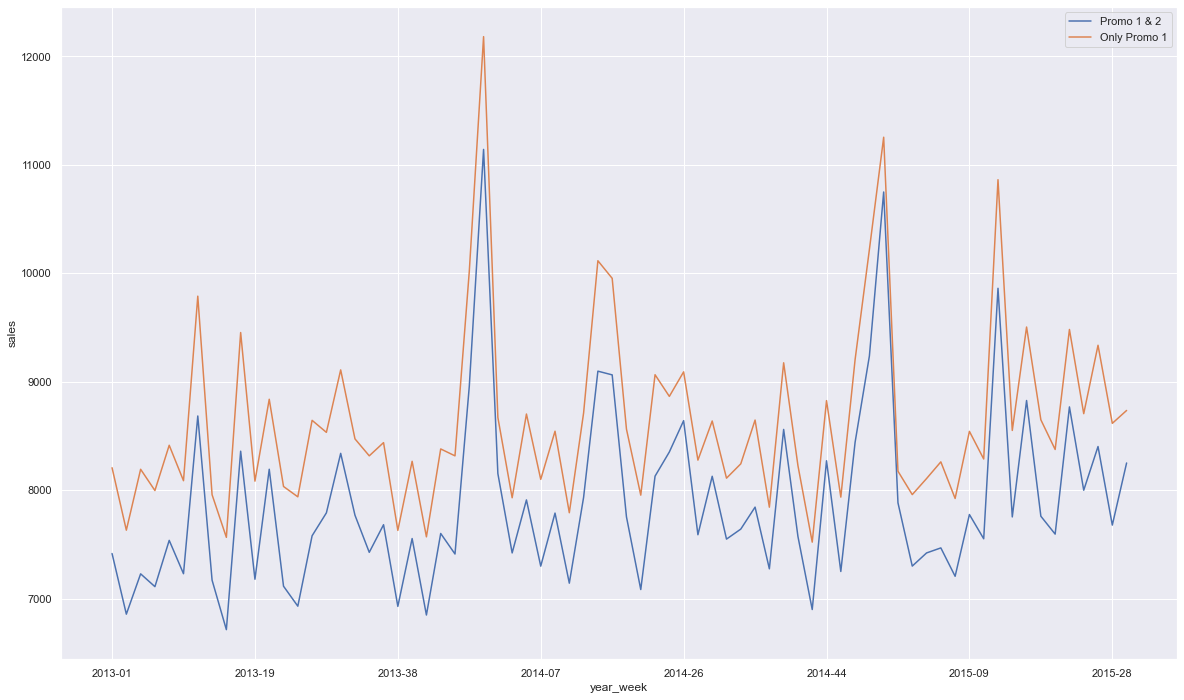

In [141]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux1.set_index('year_week',inplace=True)
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.set_index('year_week',inplace=True)
aux2.plot(ax=ax, figsize=(20,12),xlabel='year_week',ylabel='sales')

ax.legend(labels=['Promo 1 & 2', 'Only Promo 1'])
plt.show()

Sales of stores that adhere only to Promo 1 have always been higher than the ones which have adhere to both promo.

H6's veridict is that it is **false, extended promotions do not increase the sales of stores**

### H7. Stores open during Christmas holiday should sell more, on average

**True**

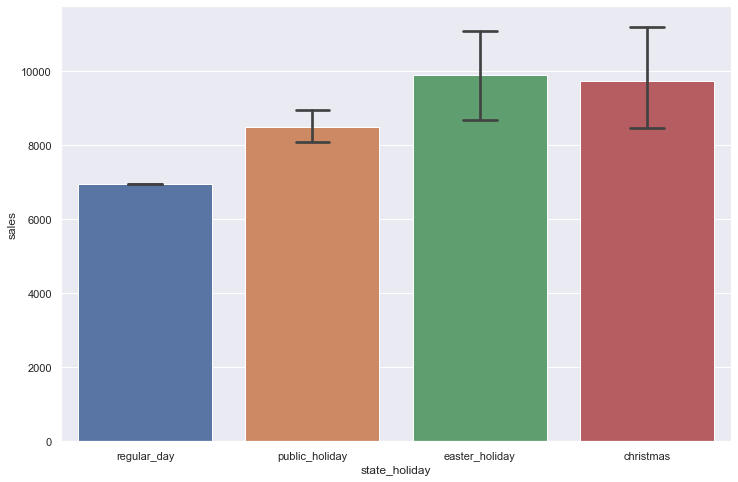

In [142]:
plt.figure(figsize=(12,8))
sns.barplot(x='state_holiday', y='sales', data=df4, estimator = np.mean, capsize=.2)
plt.show()

Christmas holiday is the second biggest holiday by sales number.

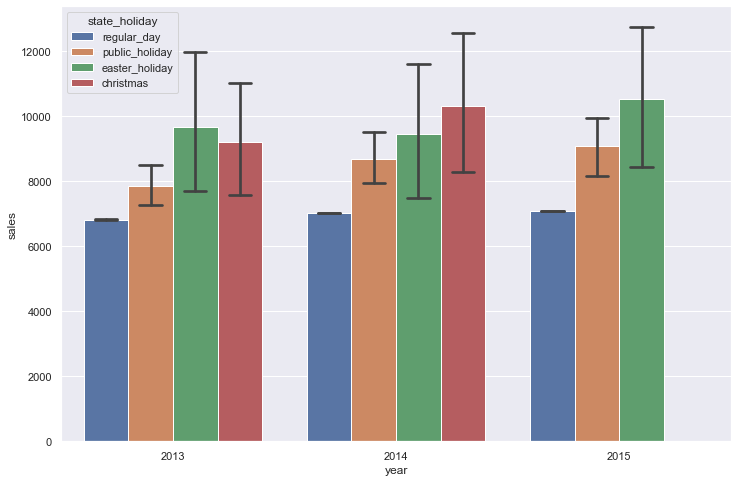

In [143]:
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='sales', hue='state_holiday', data=df4, estimator = np.mean, capsize=.1)
plt.show()

It is seen that Christmas holiday, accompanied by Easter, are the holidays that have more sales. Also, from 2013 to 2014 the sales on Christmas had an increase.

Thus, hypothesis H7's veridict is that it is **true, sales during Cristmas holiday can be higher compared to sales on public holidays and regular days**

### H8. Stores should sell more over the years, on average

**Inconclusive**

<AxesSubplot:>

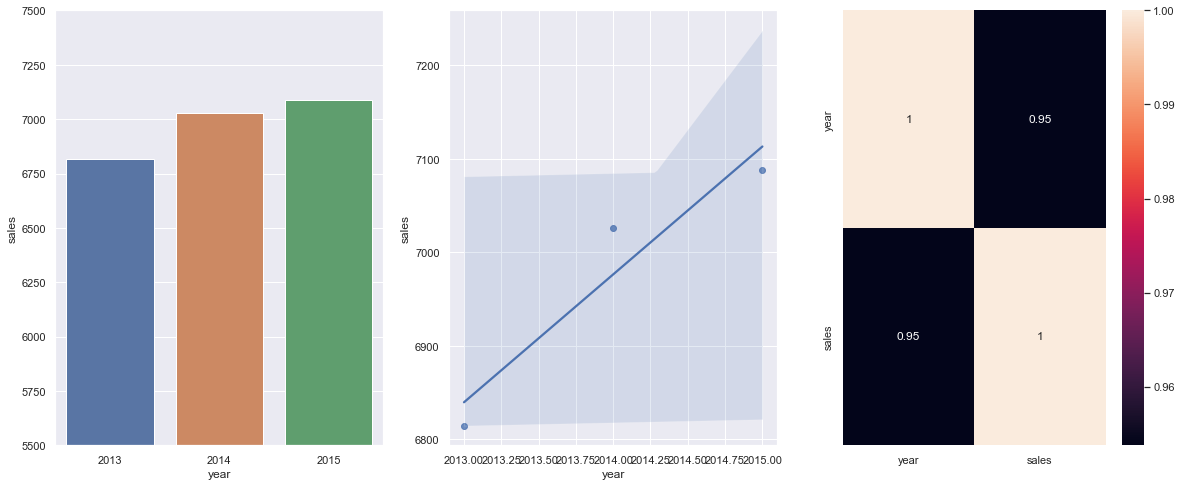

In [144]:
aux1 = df4[['sales','year']].groupby('year').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='year', y='sales', estimator=np.mean, ci='sd', capsize=.1)
plt.ylim([5500, 7500])
sns.axes_style

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales')


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)




Since we have only 2 years (2013 and 2014) with data from 01/01 to 31/12, this analysis can not be validated, once the rest of 2015's year could affect the validation of hypothesis H8. 

Thus, the veridict for H8 is: **inconclusive, we don't have enough data to validate ou refute this hypothesis**

### H9. Stores should sell more in the second half of the year, on average

**False**

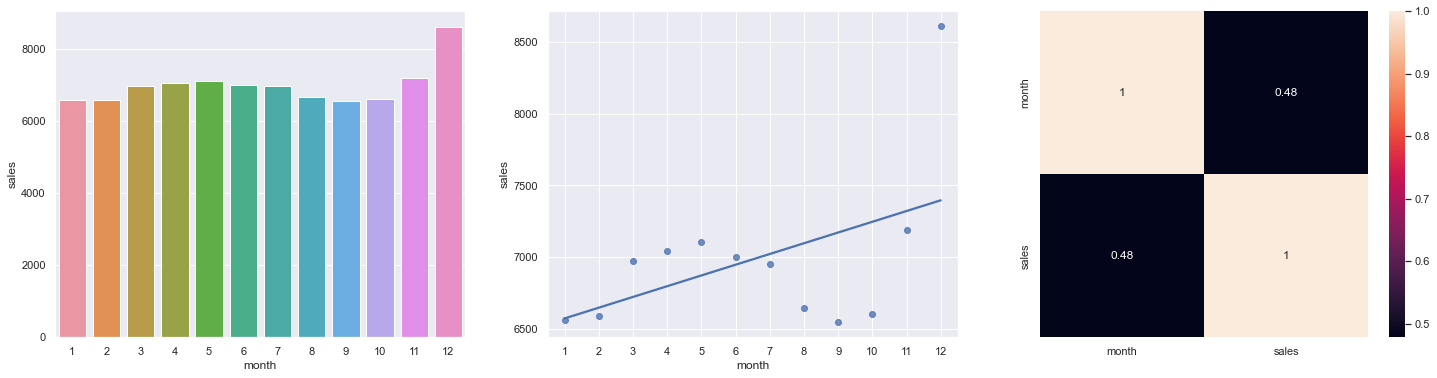

In [145]:
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
sns.barplot(data=aux1,x='month',y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='month',y='sales',ci=None)
plt.xlim(0.5, 12.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel;

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()





It is inconclusive to say if the second half of the year sells more or less than the first half, but it's noticed that the second half concentrate the most part of data with low sales. For this, a new analysis can be performed:

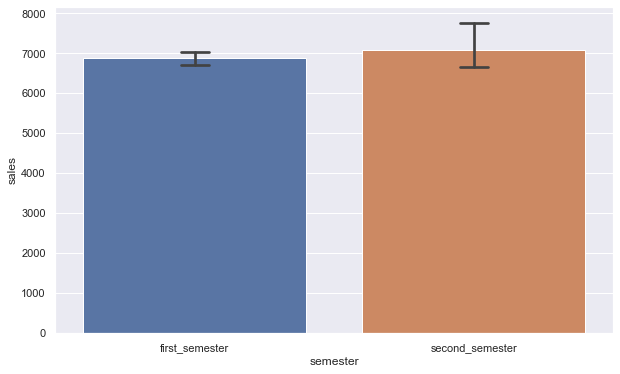

In [146]:
aux1['semester'] = aux1['month'].apply(lambda x: 'first_semester' if x <= 6 else 'second_semester')

plt.figure(figsize=(10,6))
sns.barplot(data=aux1, x='semester',y='sales',capsize=.1);

On average, it is seen that the second semester is slightly better on sales than the first. Also, it can be explained by the November and December months, that represent the months with highest sales.

In general, as it was explained above the bar chart, the second half of the year concentrates the lowest sales. Thus, the H9's veridict is that it is **false, it is not possible to conclude that the second half of the year has more sales, although the average is slightly higher.**

### H10. Stores should sell more after the 10th day of each month, on average

**False**

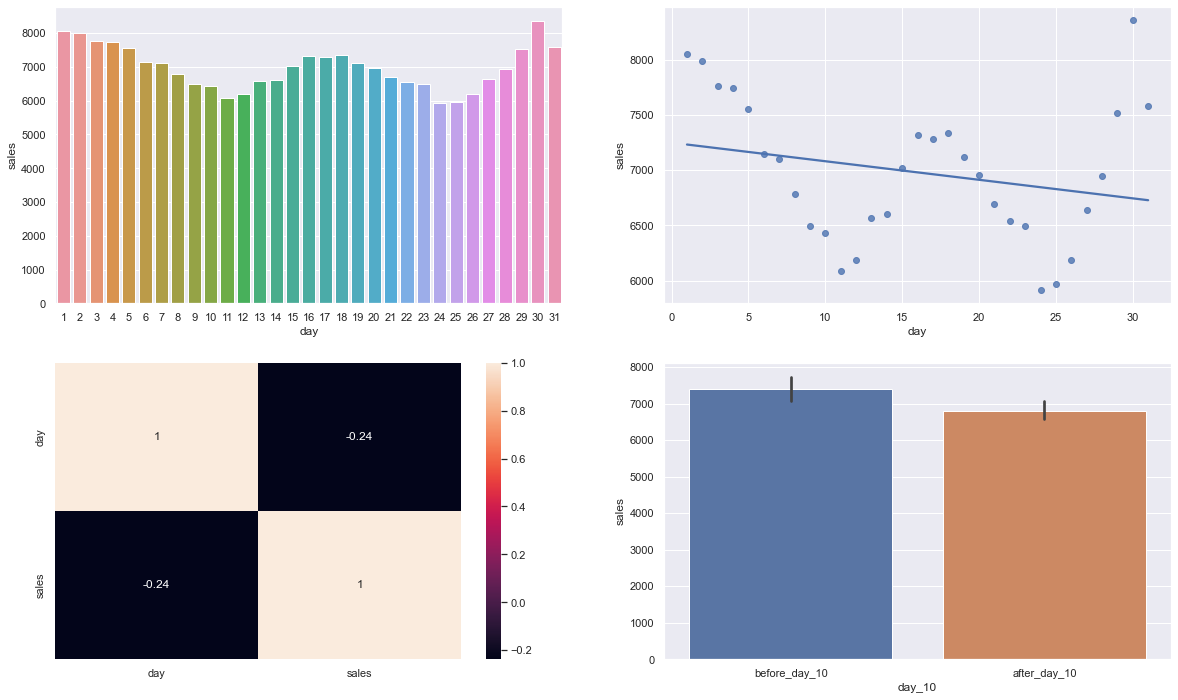

In [147]:
aux1 = df4[['sales','day']].groupby('day').mean().reset_index()

aux1['day_10'] = aux1['day'].apply(lambda x: 'before_day_10' if x < 10 else 'after_day_10')

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales')

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales', ci=None)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

plt.subplot(2,2,4)
sns.barplot(data=aux1, x='day_10', y='sales');

The composition of the 2 top graphs shows that the highest sales concentration are in the beggining and in the end of the months. The sales tend to decrease over the month.

Due to the average sales being higher before the 10th day of the month and the decrease tendency over the month's days, the veridict of H10 is that it is **false, stores do not sell more after the 10th day of the month**

### H11. Stores should sell less on weekends, in total

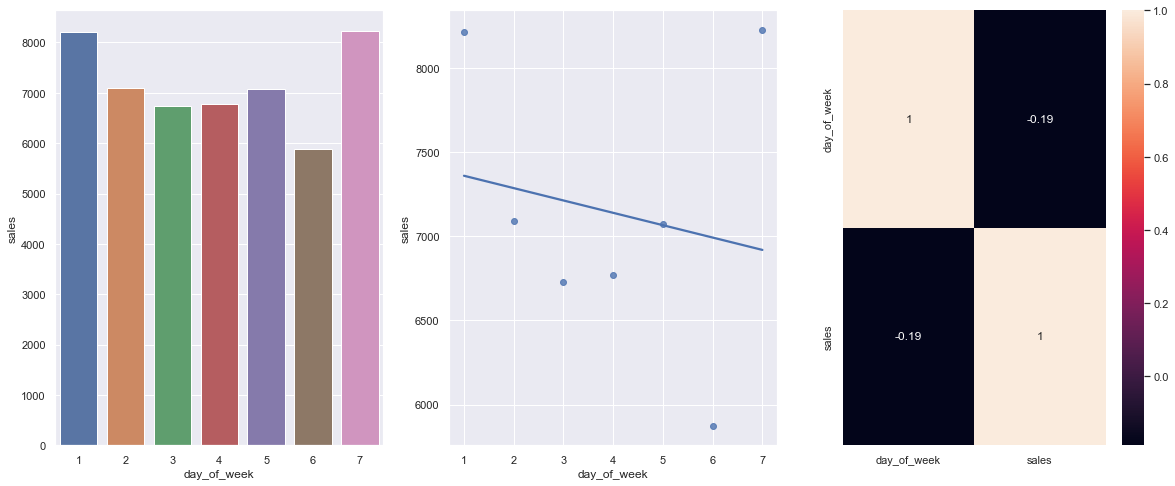

In [148]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='day_of_week', y='sales')

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales', ci=None)
# plt.xlim(0.5, 7.5)


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


On average, saturdays lower sales, while Mondays and Sundays have the highest sales. However, if we analyze the sum contributions in each day for the sales, the scenario changes:

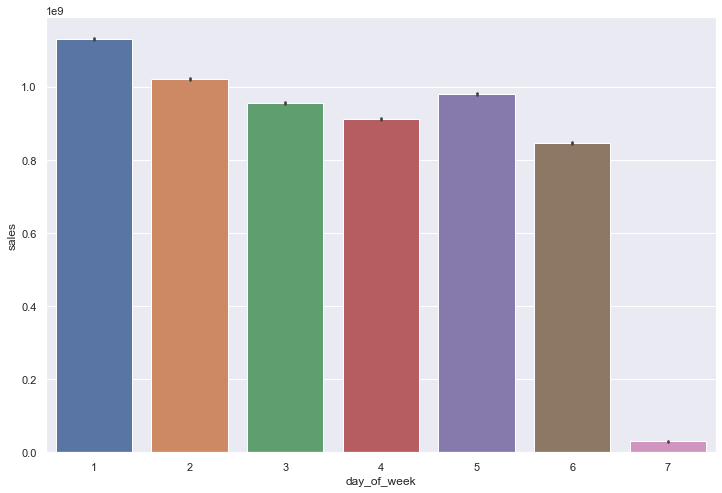

In [149]:
plt.figure(figsize=(12,8))
sns.barplot( data=df4, x='day_of_week', y='sales', estimator = np.sum)
plt.show()

It is seen that Weekends, specially Sundays, have the lowest amount of sales of all days. This can be explained due the fact that many stores do not open on Sundays, but as we saw above, the ones which open have great sales results.

The veridict for H11 is that it is **true, on weekends the sales total is lower than in regular days**

### H12. Stores should sell less during school holidays, on average

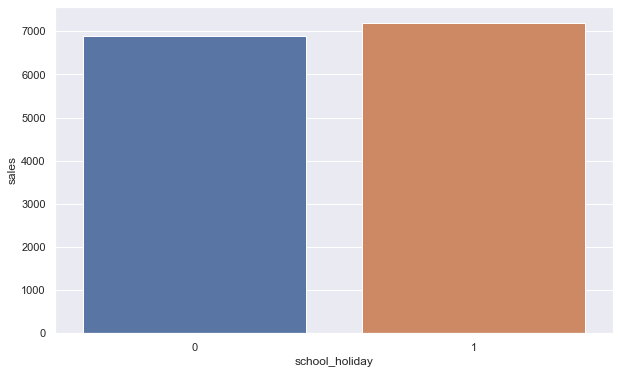

In [150]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=aux1, x='school_holiday', y='sales');

On average, it is seen that stores sell more on school holidays.

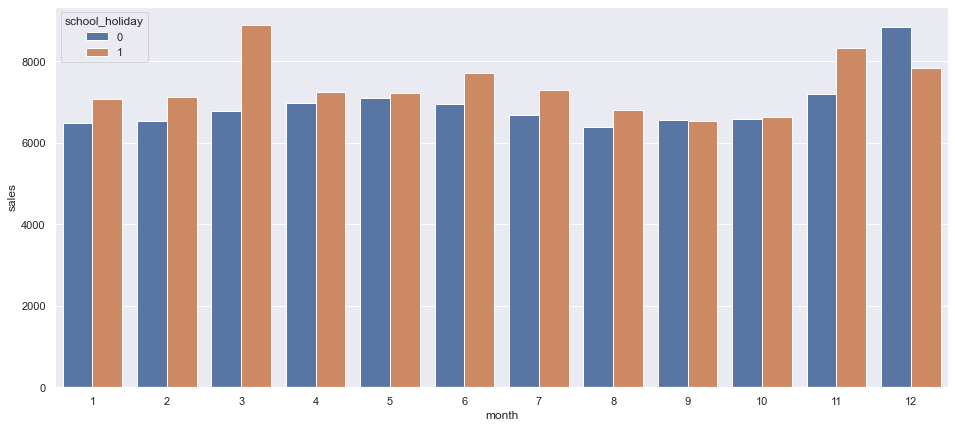

In [151]:
plt.figure(figsize=(16,7))
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(data = aux1, x='month', y = 'sales', hue='school_holiday');

With the exception of September and December, the average sales are higher on school holidays.

H12's veridict is that it is **false, on school holidays stores sell more**

### 4.2.1 Summary of hypotheses

## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

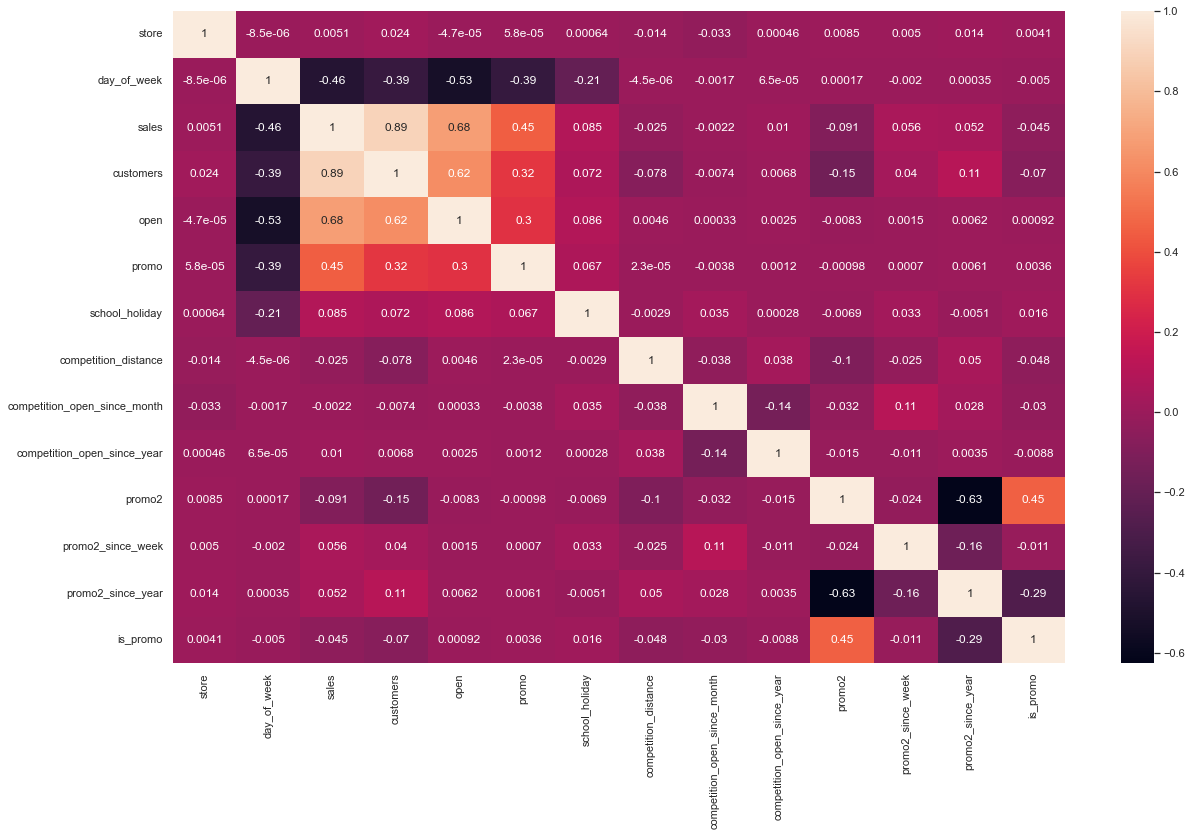

In [152]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

The correlation between the categorical variables

In [153]:
from scipy import stats

In [154]:
cat_attributes = df4.select_dtypes(include = 'object')

<AxesSubplot:>

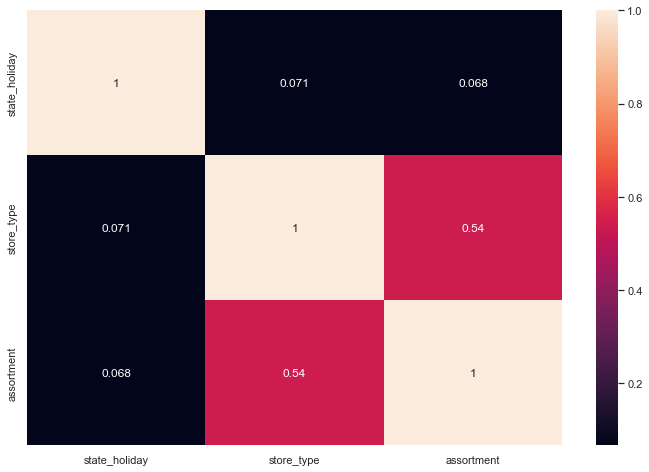

In [155]:
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]
              })

d = d.set_index(d.columns)

plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True)


# 5.0 DATA PREPARATION

In this section, the data will be prepared to be applied to a machine learning model. This involves filtering the most relevant variables for the model learning.

In [156]:
# CRISP

In addition, machine learning models are facilitated for numerical variables and data on the same scale. So the next steps will be dedicated to transforming the variables into the same magnitude order by applying three different methods.

In [157]:
df5 = df4.copy()

## 5.1 Normalization

Normalization is a method used to place variables with a normal distribution into a 0 centered range with a ±1 standard deviation.

It is seen in section 4.1.2 that neither of data variables have a normal distribution behavior. So this method will not be applied in this project.

## 5.2 Rescaling

The Rescaling method can be **MinMaxScaler** or **RobustScaler**. 

The choice between them depends on whether or not data have outliers.

First, Rescaling will be applied to non-cyclical variables:
- 'competition distance'
- 'year'
- 'competition time month'
- 'promo time week'

In [158]:
a = df5.select_dtypes(include=['int64','float64'])

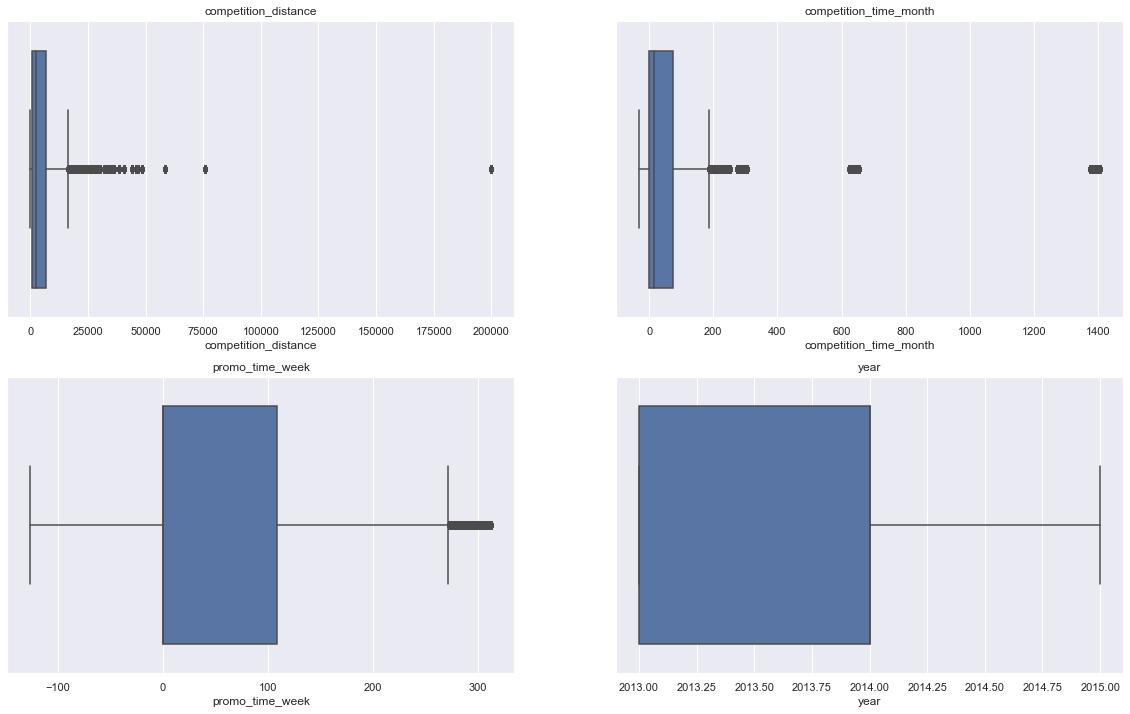

In [159]:
# competition distance
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.boxplot(x = df5['competition_distance'])
plt.title('competition_distance')

# competition time month
plt.subplot(2,2,2)
sns.boxplot(x = df5['competition_time_month'])
plt.title('competition_time_month')

# promo time week
plt.subplot(2,2,3)
sns.boxplot(x = df5['promo_time_week'])
plt.title('promo_time_week')

# year
plt.subplot(2,2,4)
sns.boxplot(x = df5['year'])
plt.title('year');



In section 1.5, 'competition_distance' NaN values were filled with 200k values, representing the competitors that were too far from the stores. Since this variable shows outliers, RobustScaler will be applied to it. Also, the presence of outliers in 'competition_time_month' requires the use of Robust Scaler

Outliers are not so representative in 'promo_time_week' and 'year' variables, so it will be used the MinMaxScaler.

In [160]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)



## 5.3 Transformation

### 5.3.1 Non-cyclical features encoding

The 3 non-cyclical variables will be encoded here:
- 'state_holiday'
- 'store_type'
- 'assortment'

In [161]:
# state holiday - One Hot Encoding: great work for 'states', such as holidays
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding: works for categories that without any specific magnitude  
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding: works fot categories with manigtude order.
assortment_dict = {'basic':1,
                   'extended':2,
                   'extra':3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Cyclical features encoding

In this section, some features need to be represented as cyclicals. 

This nature can be encoded splitting variables' intervals into sine and cosine of a circle.

In [162]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# day - Since some months have 28/29, 30 or 31 days, 
# this will be taken in consideration for this transformation

# max number of days
max_days_month = df5[['month','day']].groupby('month')['day'].max().to_dict()

df5['max_days_month'] = df5['month'].map(max_days_month)

# days
df5['day_sin'] = df5.apply(lambda x: np.sin(x['day']*(2*np.pi/x['max_days_month'])), axis=1)
df5['day_cos'] = df5.apply(lambda x: np.cos(x['day']*(2*np.pi/x['max_days_month'])), axis=1)

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

### 5.3.3 Target variable transformation

In [163]:
df5['sales'] = np.log1p(df5['sales'])

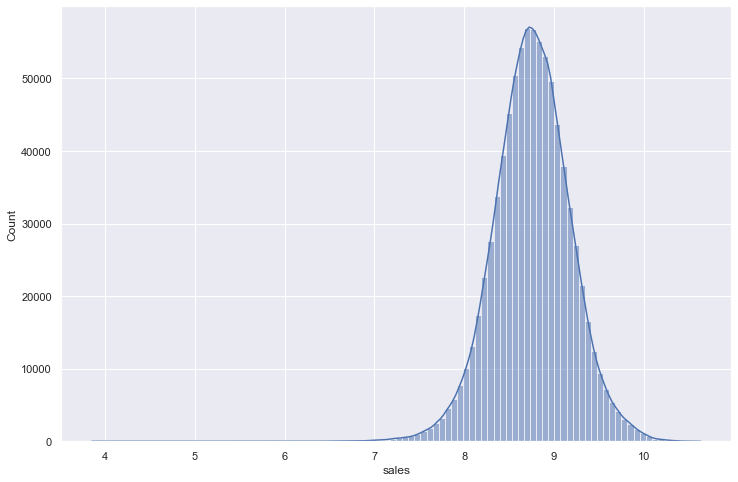

In [164]:
sns.histplot(x=df5['sales'], bins=100,kde=True);

# 6.0 FEATURE SELECTION

"The simplest solution is almost always the best." (Occam's Razor)

In [165]:
df6 = df5.copy()

cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week', 'max_days_month']
df6 = df6.drop(columns= cols_drop, axis = 1)

## 6.1 Split dataframe into train and test dataset 

The training dataframe will be the data up to 6 weeks. The testing data will be rest.

The max date is found and then it is subtracted 6 week from it.

In [166]:
# subtracted 6 weeks from the max date 
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

Now, it is known that last 6 weeks from the dataset starts on June 19th. 

In [167]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# testing dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

### 6.2.1 Best features from boruta

## 6.3 Manual feature selection

In [247]:
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2',
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin', # manual
                        'month_cos', 
                        'day_of_week_sin', 
                        'day_of_week_cos',
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_sin', # manual
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELING

In this section, we're starting machine learning modeling.

In [254]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model

In [206]:
aux0 = x_train.copy()
aux0['sales'] = y_train.copy()

aux1 = x_test.copy()

# prediction
aux2 = aux0[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# # performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.763326,0.216814,1939.32873


## 7.2 Linear Regression

In [208]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1860.629948,0.291807,2660.719963


## 7.3 Regularized linear regression

In [236]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Regularized Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Regularized Linear Regression,1891.356633,0.289331,2743.055113


## 7.4 Random forest regressor

In [221]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,664.362646,0.099036,971.436167


## 7.5 XGBoost regressor

In [231]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.3,
                             max_depth=6,
                             subsample=1,
                             colsample_bytree=1).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,874.913223,0.130394,1262.775493


## 7.6 Model performance

In [238]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,664.362646,0.099036,971.436167
0,XGBoost Regressor,874.913223,0.130394,1262.775493
0,Average Model,1429.763326,0.216814,1939.328730
0,Linear Regression,1860.629948,0.291807,2660.719963
0,Regularized Linear Regression,1891.356633,0.289331,2743.055113


In [255]:
x_training = X_train[cols_selected_boruta]

In [274]:
mae_list = []
mape_list = []
rmse_list = []
for k in reversed(range(1, 6)):
    print('\nKFold Number: {}'.format(k))
    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] >= validation_end_date)]

    # training and validation dataset
    xtraining = training.drop(columns=['date','sales'], axis=1)
    ytraining = training['sales']

    xvalidation = validation.drop(columns=['date','sales'], axis=1)
    yvalidation = validation['sales']

    # model
    lr = LinearRegression().fit(xtraining, ytraining)


    # prediction
    yhat_lr = lr.predict(xvalidation)

    # performance
    lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))
    mae_list.append(lr_result['MAE'])
    mape_list.append(lr_result['MAPE'])
    rmse_list.append(lr_result['RMSE'])

    {'MAE CV': mae_list}


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [277]:
lr_result['MAE']

0    1787.467039
Name: MAE, dtype: float64